## Warehouse 환경

In [1]:
import os
import numpy as np
from crewai import Agent, Task, Crew
from environment import Environment
import configs
import pickle

os.environ["OPENAI_API_KEY"] = ""

In [2]:
class Experiment:
    def __init__(self, startx, starty, goalx, goaly, scaleX=None, scaleY=None, bucket=None, distance=None, map_name=None):
        self.startx = startx
        self.starty = starty
        self.goalx = goalx
        self.goaly = goaly
        self.scaleX = scaleX
        self.scaleY = scaleY
        self.bucket = bucket
        self.distance = distance
        self.map_name = map_name

    def __str__(self):
        return f"Experiment(start=({self.startx}, {self.starty}), goal=({self.goalx}, {self.goaly}), map={self.map_name})"

def load_scenarios(filename):
    experiments = []
    with open(filename, 'r') as file:
        first_line = file.readline().strip()
        if first_line.startswith("version"):
            _, version = first_line.split()
            version = float(version)
        else:
            version = 0.0
            file.seek(0)

        if version == 0.0:
            for line in file:
                bucket, map_name, startx, starty, goalx, goaly, distance = line.split()
                experiments.append(Experiment(int(startx), int(starty), int(goalx), int(goaly),
                                              bucket=int(bucket), distance=float(distance), map_name=map_name))
        elif version == 1.0:
            for line in file:
                bucket, map_name, scaleX, scaleY, startx, starty, goalx, goaly, distance = line.split()
                experiments.append(Experiment(int(startx), int(starty), int(goalx), int(goaly), int(scaleX), int(scaleY),
                                              bucket=int(bucket), distance=float(distance), map_name=map_name))
        else:
            raise ValueError("Unsupported version number")

    return experiments

filename = 'C:\\Users\\Owner\\MAPF\\scen-random\\warehouse-10-20-10-2-1-random-1.scen'
experiments = load_scenarios(filename)
for exp in experiments:
    print(exp)

Experiment(start=(143, 57), goal=(10, 16), map=warehouse-10-20-10-2-1.map)
Experiment(start=(134, 28), goal=(91, 6), map=warehouse-10-20-10-2-1.map)
Experiment(start=(66, 7), goal=(36, 56), map=warehouse-10-20-10-2-1.map)
Experiment(start=(25, 49), goal=(48, 49), map=warehouse-10-20-10-2-1.map)
Experiment(start=(104, 1), goal=(112, 13), map=warehouse-10-20-10-2-1.map)
Experiment(start=(72, 46), goal=(110, 58), map=warehouse-10-20-10-2-1.map)
Experiment(start=(155, 1), goal=(154, 41), map=warehouse-10-20-10-2-1.map)
Experiment(start=(19, 43), goal=(17, 10), map=warehouse-10-20-10-2-1.map)
Experiment(start=(21, 42), goal=(39, 37), map=warehouse-10-20-10-2-1.map)
Experiment(start=(155, 6), goal=(78, 28), map=warehouse-10-20-10-2-1.map)
Experiment(start=(119, 4), goal=(73, 28), map=warehouse-10-20-10-2-1.map)
Experiment(start=(101, 19), goal=(38, 19), map=warehouse-10-20-10-2-1.map)
Experiment(start=(58, 13), goal=(143, 54), map=warehouse-10-20-10-2-1.map)
Experiment(start=(70, 61), goal=(

In [3]:
#negotiator를 구성하기 위한 union find 알고리즘

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

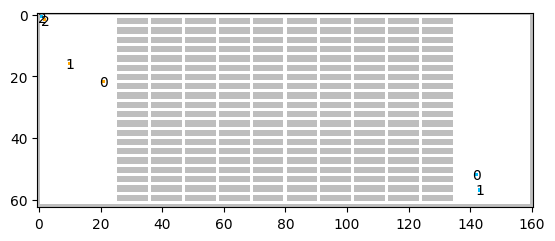

In [4]:
with open('C:\\Users\\Owner\\MAPF\\warehouse-10-20-10-2-1.txt', 'r', encoding='utf-8') as file:
    content = file.read()

content = content.replace('T', '1')
content = content.replace('.', '0')

map_start_index = content.find('map') + len('map')

map_content = content[map_start_index:].strip()

map_lines = [list(line.strip()) for line in map_content.split('\n') if line.strip()]

map_array = np.array(map_lines, dtype=int)

toy = (map_array, np.array([[52, 142], [57, 143], [1, 1]]), np.array([[22, 21], [16, 10], [2, 2]]))

num_agents = len(toy[1])

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

In [5]:
directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

class PathFindingAgents:
  def path_finder(self, agent_number):
    return Agent(
      role='Path finder',
      goal='Start at the start point and reach the end point without crashing into a wall.',
      backstory=f"""You are a veteran adventurer with a great sense of direction.
      You understand which direction you need to move to get from where you are to where you want to go.
      Your agent number is {agent_number}.
      """,
      verbose=True
    )
    
  def negotiator(self):
    return Agent(
      role='Negotiator',
      goal="""Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.""",
      backstory="""You're a veteran overseer, and you've been called in to resolve the deadlock, as each agent is in the other's line of sight.
      """,
      verbose=True,
    )
	
class PathFindingTasks():
  def path_finding(self, agent, x, y, x_finish, y_finish, east, west, north, south, last_action):
    return Task(
      description=(
        f"""
        Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
        East and west in the coordinates correspond to the x axis.
        South and north in the coordinates correspond to the y axis.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        Which direction do you move next?
        {last_action}
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )
    
  def negotiate(self, agent):
    return Task(
      description=(
        f"""
        Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.
        The planned moves of each agent represent the previous outcomes.
        """
      ),
      expected_output='Direction of the agents',
      agent=agent
    )

agents = PathFindingAgents()
tasks = PathFindingTasks()

agents_set = [agents.path_finder(i) for i in range(num_agents)]
negotiator = agents.negotiator()

In [6]:
#에이전트들의 지난번 액션들
action_list = [[] for _ in range(num_agents)]



> Entering new CrewAgentExecutor chain...


2024-06-11 13:36:19,814 - 9972 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position at (142,10), my destination is at (21,40). This means I need to move west (to decrease my x value from 142 to 21) and north (to increase my y value from 10 to 40). However, I can only make one move at a time. Given that the x-axis disparity is greater, I'll prioritize moving along the x-axis. Since there's a path to the west, I'll proceed in that direction.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 13:36:22,369 - 9972 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


After considering the coordinates, I need to move towards the west to reduce the x-coordinate and north to increase the y-coordinate to reach the destination.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position (1,61) and my destination (2,60), I need to move towards the east to increase my x-coordinate and then move south to decrease my y-coordinate. Since my north and west are blocked by a wall, the logical first step is to move east as it is a clear path. 

Final Answer: East

> Finished chain.


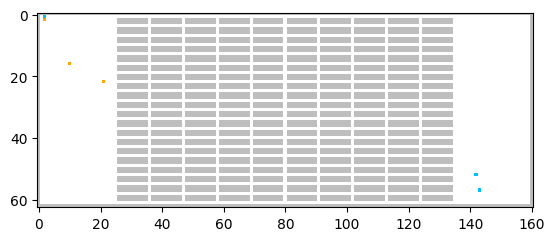

In [7]:
# 1 turn
for n in range(1):

  step = [0 for i in range(num_agents)]

  #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
  FOV_agents = []
  for i in range(num_agents):
    if np.any(env.observe()[0][i][0][2:7, 2:7]):
      non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
      non_zero_elements = [element - 1 for element in non_zero_elements]
      non_zero_elements.append(i)
      FOV_agents.append(non_zero_elements)

  #알고리즘을 이용해 연결된 집합 찾기
  connected_set = merge_sets(FOV_agents)

  #연결이 있는 모든 에이전트들
  deadlocked_agents = [item for sublist in connected_set for item in sublist]

  for i in range(num_agents):

    #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
    if i not in deadlocked_agents:
      
      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = 62-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = 62-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent."""
      else:
        last_action = """"""

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      action_list[i].append(result)
    
      step[i] = directiondict[result]

  
  #여기에 교착상태에 빠진 에이전트들을 계획.




  env.step(step)
  env.render()

### 교착상태 실험(잘 되면 위 코드로 넣기)

In [7]:
FOV_agents = []
for i in range(num_agents):
  if np.any(env.observe()[0][i][0][2:7, 2:7]):
    non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
    non_zero_elements = [element - 1 for element in non_zero_elements]
    non_zero_elements.append(i)
    FOV_agents.append(non_zero_elements)

connected_set = merge_sets(FOV_agents)
deadlocked_agents = [item for sublist in connected_set for item in sublist]

In [8]:
crew_tasks = []
crew_agents = []

for i in connected_set[0]:
    
    a_obs = env.observe()[0][i][1]
    x = env.observe()[1][i][1]
    y = 4-env.observe()[1][i][0]
    x_finish = toy[2][i][1]
    y_finish = 4-toy[2][i][0]

    if a_obs[4][3] == 0:
        west = """To your west lies a path."""
    else:
        west = """Your west is blocked by a wall."""

    if a_obs[4][5] == 0:
        east = """To your east lies a path."""
    else:
        east = """Your east is blocked by a wall."""

    if a_obs[5][4] == 0:
        south = """To your south lies a path."""
    else:
        south = """Your south is blocked by a wall."""

    if a_obs[3][4] == 0:
        north = """To your north lies a path."""
    else:
        north = """Your north is blocked by a wall."""

    if len(action_list[i]) == 0:
        last_action = """"""
    elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
    elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
    elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
    elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
    elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent."""
    else:
        last_action = """"""

    crew_tasks.append(tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action))
    crew_agents.append(agents_set[i])

In [9]:
crew_tasks.append(tasks.negotiate(negotiator))
crew_agents.append(negotiator)

crew = Crew(
    agents=crew_agents,
    tasks=crew_tasks,
    verbose=0,
)

result = crew.kickoff()

2024-06-07 20:55:54,863 - 30180 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...
Given my current location at (1,2) and my destination at (4,2), as a path finder, logically I should move towards the direction that gets me closer to the destination. In this case, the direction is towards the east as it increases the x-coordinate, bringing me closer to the destination. 

Thought: I am currently at coordinates (1,2) and I need to get to (4,2). The x-axis corresponds to the east-west direction while the y-axis corresponds to the north-south direction. Therefore, I should move east to increase my x-coordinate and get closer to the destination.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given that my current position is (3,2) and the destination is at (0,2), it is clear that we need to move in a direction that decreases our x-coordinate without changing the y-coordinate. This is because we are currently aligned with the destination on the y-axis, but we are to the east of it on the x-axis